## Buy-Box Algorithm & Supporting Algorithms


In [4]:
import random
import pandas as pd 
import os 

directory = '/Users/carlosarotine/desktop' ### CHANGE THIS ### Setting my own directory to access the very basic CSV file for initial testing 

os.chdir(directory)

df = pd.read_csv("test for final .csv") 

df2 = pd.read_csv("reviews2.csv")


def initializing(df , df2):
    # Creating the dyanmic weight function that randomly assigns weights to the different metrics in the our main buy-box algorithm
    def dynamic_weight():
        w1 = random.randint(10, 50)
        w3 = random.randint(20, 60)
        w2 = 100 - (w1 + w3)
        total = w1 + w2 + w3
        if total > 100:
            return dynamic_weight() # Recursively call the function only when the condition is not met 

        elif w2 < 0:  # If w2 is negative, adjust the range of w1 or w3
            adjustment_factor = 100 / total
            w1 *= adjustment_factor
            w2 *= adjustment_factor
            w3 *= adjustment_factor

        else:
            print('unadjusted weight:' , w1 , w2 , w3)
        return w1 / 100, w2 / 100, w3 / 100

    w1, w2, w3 = dynamic_weight()
    print(w1, w2, w3)


    #print(w1, w3) # - print statement to understand identify the weights  

    # Reading the CSV file 

    price = df['price'] # Assigning variable 'price' to have the value of price in the dataframe

    # Creating program to normalize price using min-max scaling 
    def price_norm(price):
        min_price = df['price'].min()
        max_price = df['price'].max()
        norm_price = (price - min_price) / (max_price - min_price)
        return norm_price 

    norm_price = price_norm(price) # Calling function and assigning it to variable norm_price
    #print(norm_price) # - trouble shooting print statement  

    returns = df['returns'] # Assigning variable 'returns' to have the value of returns in the dataframe

    # Creating program to normalize returns using min-max scaling 
    def norm_returns(returns): 
        min_return = df['returns'].min()
        max_return = df['returns'].max()
        norm_return = (returns - min_return) / (max_return - min_return)  
        return norm_return

    norm_return = norm_returns(returns) # Calling function and assigning it to variable norm_return
    #print(norm_return) # - trouble shooting print statement  

    # Creating dynamic returns program that reduces chances of winning for sellers with high return rates  
    # Conditions found on master document 
    def dynamic_returns(norm_returns):
        return_rates = [] 
        for returns in norm_return:
            if returns <= 0.05:
                return_rate = 2 * returns
            elif returns <= 0.20:
                return_rate = 4 * returns
            elif returns <= 0.50:
                return_rate = 6 * returns
            else:
                return_rate = 10 * returns # Once returns are greater than 0.5 
            return_rates.append(return_rate)
        return return_rates

    return_dynamic = dynamic_returns(norm_returns) # calling function and assigning to variable called 'return_dyanmic'
    #print(return_dynamic) # - checking to see if the function worked 

    fulfils = df['fulfillment'] # Assigning variable 'fulfils' with data from fulfillment column from the dataframe  

    # Creating function to check if seller is fulfilled by Noon or not. Results are binary 
    def fulfillment(fulfils): 
        fulfil_return = []
        for i in fulfils:
            if i != 'Noon':
                fulfil_return.append(0) # Condition to see if seller is not fulfilled by Noon
            else:
                fulfil_return.append(1) # Condition to see if seller is fulfilled by Noon 
        return fulfil_return


    fulfillment = pd.Series(fulfillment(fulfils))

    

    # Define function for verification to store comments that are greater than 3 characters, signifying an actual comment
    def verification(review):
        actual_reviews = review[review.str.len() > 3]
        return actual_reviews

    # Define function for star_only to store comments that are less than 3 characters 
    def star_only(review):
        star_only_reviews = review[review.str.len() < 3]
        return star_only_reviews

    # Define function for review mapping to turn results of verification function into Pandas DF
    def review_mapping(reviews, rating):
        mapped = pd.DataFrame({'Reviews': reviews, 'Rating': rating[review.isin(reviews)]})
        return mapped

    # Define function for star-only mapping to turn results of star_only function into Pandas DF
    def star_only_mapping(star_only, rating):
        star_map = pd.DataFrame({'Reviews': star_only, 'Rating': rating[review.isin(star_only)]})
        return star_map

    # Define function for review calculation
    # The threshold for star rating is 3.0, as the average rating found in our dataset is 3.0
    # These are conditions found on the master document

    def review_calculation(mapped, star_map):
        df1_reviews = len(mapped[mapped['Rating'] == 3]) 
        df2_reviews = len(mapped[mapped['Rating'] == 4])
        df3_reviews = len(mapped[mapped['Rating'] == 5])
        df1_stars = len(star_map[star_map['Rating'] == 3])
        df2_stars = len(star_map[star_map['Rating'] == 4])
        df3_stars = len(star_map[star_map['Rating'] == 5])
        reviews = (0.1 * df1_stars) + (0.2 * df1_reviews) + (0.3 * df2_stars) + (0.5 * df2_reviews) + (0.6 * df3_stars) + (1 * df3_reviews)
        return reviews

    def review_normalized(reviews):
        # Calculate the minimum and maximum values of the reviews for all sellers
        min_review = min(reviews)
        max_review = max(reviews)

        # If min and max are equal, return the original reviews to avoid division by zero
        if min_review == max_review:
            return reviews

        # Apply min-max scaling formula to each review score for all sellers
        normalized = [(review - min_review) / (max_review - min_review) for review in reviews]

        return normalized

    # Get unique sellers from the dataset
    sellers = df2['Seller'].unique()

    # Initialize list to store review scores for all sellers
    all_reviews = []

    # Iterate over each seller
    for seller in sellers:
        # Subset data for the current seller
        seller_data = df2[df2['Seller'] == seller]

        # Extract review and rating columns for the subset
        review = seller_data['review_description']
        rating = seller_data['rating']

        # Get actual reviews and star-only reviews
        actual_reviews = verification(review)
        star_only_reviews = star_only(review)

        # Create mappings for reviews and star-only reviews
        mapped = review_mapping(actual_reviews, rating)
        star_map = star_only_mapping(star_only_reviews, rating)

        # Calculate reviews for the current seller
        reviews = review_calculation(mapped, star_map)

        # Append reviews as a list for the current seller
        all_reviews.append([reviews])

    # Flatten the list of reviews
    flattened_reviews = [score for sublist in all_reviews for score in sublist]

    # Normalize the reviews for all sellers using min-max scaling
    scaled_reviews = review_normalized(flattened_reviews)

    # Print scaled reviews to verify
    print("Scaled Reviews:", scaled_reviews) # - Troubleshooting print statement  


    df['review_score'] = scaled_reviews

    norm_review = df['review_score']


    def buy_box(w1, w2, w3, norm_price, norm_review, return_dynamic, fulfillment):
        score = ((-w1 * norm_price) + (w2 * norm_review) + (w3 * fulfillment)) - return_dynamic # Based on formula found on master document 
        modified_score = []
        for s in score:
            if s < 0: # Since negative values represent a return rate higher than the actual bb score, an automatic 1 is appended instead to disqualify
                modified_score.append(0)
            else:
                modified_score.append(s) # If the scores are positive, the actual score is displayed
        print(modified_score) # Looking at every score
        top_three = sorted(modified_score, reverse = True)[:3] # Returns the winner and runner-ups 
        return top_three
        #return modified_score


    score = buy_box(w1, w2, w3, norm_price, norm_review, return_dynamic, fulfillment) # Calling function and assigning to variable titled 'score'
    
    scores = score
    
    return scores

scores = initializing(df, df2)
print(scores)

unadjusted weight: 50 22 28
0.5 0.22 0.28
Scaled Reviews: [0.7081939799331103, 0.06605351170568562, 0.0, 0.1387959866220736, 0.01421404682274244, 1.0, 0.5142140468227424, 0.8503344481605353, 0.032608695652173905]
[0, 0, 0.2703798428984757, 0, 0, 0, 0, 0.17530625879941628, 0.22021048029504842]
[0.2703798428984757, 0.22021048029504842, 0.17530625879941628]


## GUI Block

/Users/carlosarotine/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


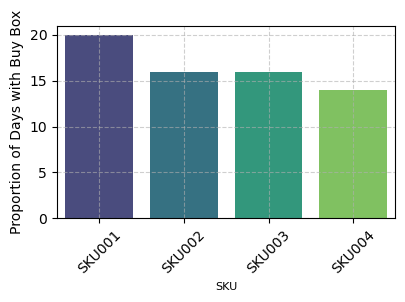

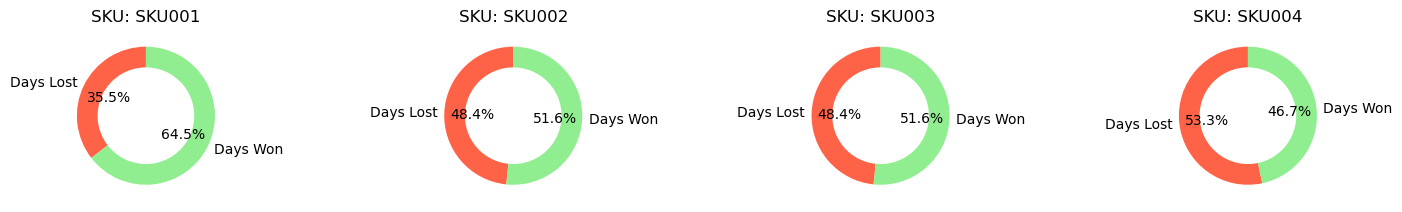

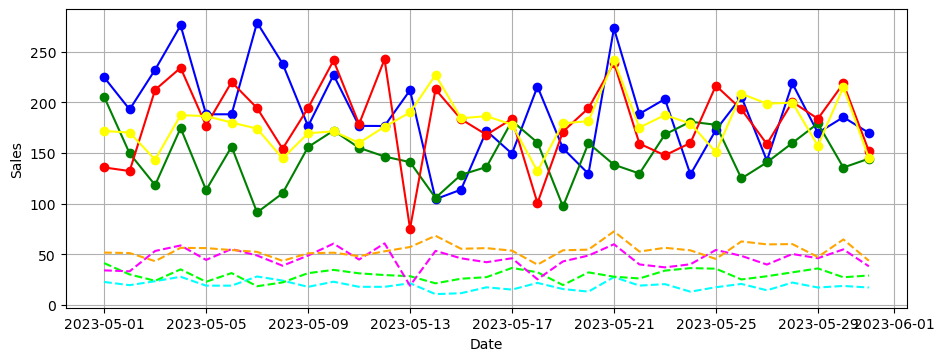

In [1]:
import pandas as pd
import tkinter as tk
from tkinter import PhotoImage
from tkinter import ttk
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np

np.random.seed(42)

file_path = '/Users/carlosarotine/desktop/buybox.xlsx'
data = pd.read_excel(file_path)


class WelcomeScreen:
    def __init__(self):
        self.app = tk.Tk()
        self.app.title("Noon Buy-Box Dashboard")
        self.app.geometry("1480x800")
        self.app.configure(bg="#FCEF33")
        self.app.iconbitmap('/Users/carlosarotine/desktop/gui_elements.ico')
        self.label = tk.Label(self.app, text="Welcome", font=('Hiragino Sans', 79) , bg = "#FCEF33", fg="#333333")
        self.label.place(x=500, y=200, height=400, width=400)
        
        self.welcome_noon = PhotoImage(file = '/Users/carlosarotine/desktop/gui_elements/welcome_noon_logo.png')
        self.welcome_noon_label = tk.Label(image = self.welcome_noon)
        self.welcome_noon_label.image = self.welcome_noon_label # Reference 
        self.welcome_noon_label.place(x = 590 , y = 100 , height = 200 , width = 200)
        
        self.welcome_btn_image = PhotoImage(file = '/Users/carlosarotine/desktop/gui_elements/continue_button.png')
        self.img_label = tk.Label(image = self.welcome_btn_image )
       # self.img_label.place(x = 530 , y = 520 , height = 130 , width = 320)
        self.welcome_button = tk.Button(self.app , image = self.welcome_btn_image , command = self.open_buy_box_app, 
                                        bg="#FFFFFF", borderwidth = 100 , highlightbackground="#FCE933" , highlightcolor="#FFFFFF")
        self.welcome_button.image = self.welcome_btn_image # Reference 
        self.welcome_button.place(x = 560 , y = 520 , height = 80 , width = 250)
        self.app.mainloop()
    
    
    def open_buy_box_app(self):
        self.app.destroy()  
        buy_box_app()
        

class buy_box_app:
    def __init__(self):
        np.random.seed(42)
        options = ['Select your view:', 'Overview (Simple)' , 'Overview (Detailed)', 'SKU 1', 'SKU 2', 'SKU 3', 'SKU 4']
        self.app = tk.Tk()
        self.app.geometry("1480x800")
        self.app.configure(bg = 'white')
        self.app.title("Noon Buy-Box Dashboard")
        title_banner_text = "Seller\nDashboard"
        self.noon_rect = tk.Label(self.app, text = "" , bg = "#FCE933")
        self.noon_rect.place(x = 0 , y = 0 , height = 100 , width = 4000)
        self.banner_label = tk.Label(self.app , text = title_banner_text , font = ('Hiragino Sans', 20) , bg = "#FCE933", justify="left")
        self.banner_label.place(x = 250 , y = 20 , height = 61 , width = 130)
        
        self.noon_logo = PhotoImage(file = '/Users/carlosarotine/desktop/gui_elements/noon_logo.png')
        self.noon_logo_label = tk.Label(image = self.noon_logo)
        self.noon_logo_label.image = self.noon_logo_label # Reference 
        self.noon_logo_label.place(x = 0 , y = 0 , height = 100 , width = 250)
        
        self.drop_var = tk.StringVar(self.app)
        self.drop_var.set(options[2]) 

        self.drop_menu = tk.OptionMenu(self.app, self.drop_var, *options, command=self.on_select)
        self.drop_menu.place(x = 1100 , y = 100 , height = 50 , width = 150)
        
        self.open_bb_btn = tk.Button(text = 'Open Buy Box Dashboard' , command = self.open_bb_screen)
        self.open_bb_btn.place(x = 850 , y = 100 , width = 200 , height = 50)        
        
        self.frame_1 = ttk.Frame(self.app)
        self.frame_1.place(x = 0 , y = 200 , width = 100 , height = 100)
        self.add_visual1()
        
        self.label = tk.Label(self.app , text = "Number of Days Winning the Buy Box" , font = ('Hiragino Sans' , 15 , 'bold') , bg = '#FFFFFF', justify="left")
        self.label.place(x = 0 , y = 100 ,  height = 100 , width = 400)
        
        self.label = tk.Label(self.app , text = "Daily Sales and Lost Sales" , font = ('Hiragino Sans' , 15, 'bold') , bg = '#FFFFFF')
        self.label.place(x = 500 , y = 100 ,  height = 100 , width = 300)
    
        
        self.frame_2 = ttk.Frame(self.app)
        self.frame_2.place(x = 0 , y = 500 , width = 900 , height = 900)
        self.add_visual2()

        self.frame_3 = ttk.Frame(self.app)
        self.frame_3.place(x= 800 , y = 200 , width = 100 , height = 100)
        self.add_visual3()
        
        self.label = tk.Label(self.app , text = "Number of Days Winning" , font = ('Hiragino Sans' , 15, 'bold') , bg = '#FFFFFF')
        self.label.place(x = 100 , y = 500 ,  height = 50 , width = 300)
        
        self.more_info_button1 = PhotoImage(file='/Users/carlosarotine/desktop/gui_elements/more_info.png')
        self.more_info_1_btn = tk.Button(self.app, image=self.more_info_button1, command=self.open_vis_1, borderwidth=100)
        self.more_info_1_btn.image = self.more_info_button1  # Keeping a reference to the image
        self.more_info_1_btn.place(x=400, y=120, height=80, width=80)
        
        self.more_info_button2 = PhotoImage(file='/Users/carlosarotine/desktop/gui_elements/more_info.png')
        self.more_info_2_btn = tk.Button(self.app, image=self.more_info_button2, command=self.open_vis_2, borderwidth=100, bg = 'white')
        self.more_info_2_btn.image = self.more_info_button2  # Keeping a reference to the image
        self.more_info_2_btn.place(x=1300, y=120, height=80, width=80)
        
        self.more_info_button3 = PhotoImage(file='/Users/carlosarotine/desktop/gui_elements/more_info.png')
        self.more_info_3_btn = tk.Button(self.app, image=self.more_info_button3, command=self.open_vis_3, borderwidth=100, bg = 'white')
        self.more_info_3_btn.image = self.more_info_button3  # Keeping a reference to the image
        self.more_info_3_btn.place(x=0, y=500, height=80, width=80)
        
        
        self.app.mainloop()
        
        
    def add_visual1(self):
        data['Date'] = pd.to_datetime(data['Date'])
        buybox_days = data.groupby('SKU').agg({'Buybox': 'sum'})
        total_days = data['Date'].dt.to_period('M').nunique() * data['SKU'].nunique() / data['SKU'].nunique()
        buybox_ratio = buybox_days['Buybox'] / total_days

        fig, ax = plt.subplots(figsize=(5, 2))
        sns.barplot(x=buybox_ratio.index, y=buybox_ratio, palette="viridis", ax=ax)
        ax.set_xlabel('SKU', fontsize=8)
        ax.set_ylabel('Proportion of Days with Buy Box', fontsize=10)
        ax.tick_params(axis='x', rotation=45)  # Adjust x-axis labels rotation
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 0 , y = 200 , width = 400 , height = 400)
        
        
    def add_visual2(self):
        lost_buybox_days = data.groupby('SKU').agg({'Buybox': lambda x: len(x) - x.sum()})
        total_days_per_sku = data.groupby('SKU').agg({'Date': 'nunique'})
        # Calculate the average percentage of days lost the Buy Box
        average_lost_ratio = (lost_buybox_days['Buybox'] / total_days_per_sku['Date']) * 100
        # Create a ring plot (doughnut chart) for each SKU showing the percentage of days won and lost the Buy Box
        fig, ax = plt.subplots(1, 4, figsize=(10, 5))
        # Loop through each SKU to create individual ring graphs
        for i, (sku, value) in enumerate(average_lost_ratio.items()):
            sizes = [value, 100 - value]  # Days lost and days won percentages
            labels = ['Days Lost', 'Days Won']
            ax[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['tomato', 'lightgreen'],
                        wedgeprops=dict(width=0.3))
            ax[i].set_title(f'SKU: {sku}')
        plt.tight_layout()

        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 0 , y = 500 , width = 1480 , height = 350)

    
    def add_visual3(self):
        np.random.seed(42)
        dates = pd.date_range(start='2023-05-01', end='2023-05-31', freq='D')
        data_sku1 = np.random.normal(loc=200, scale=50, size=len(dates))
        data_sku2 = np.random.normal(loc=150, scale=30, size=len(dates))
        data_sku3 = np.random.normal(loc=180, scale=40, size=len(dates))
        data_sku4 = np.random.normal(loc=180, scale=25, size=len(dates))

        df = pd.DataFrame({
            'Date': dates,
            'SKU1_Avg_Daily_Sales': data_sku1,
            'SKU2_Avg_Daily_Sales': data_sku2,
            'SKU3_Avg_Daily_Sales': data_sku3,
            'SKU1_Est_Sales_Lost': data_sku1 * 0.1,  
            'SKU2_Est_Sales_Lost': data_sku2 * 0.2,  
            'SKU3_Est_Sales_Lost': data_sku3 * 0.25,
            'SKU4_Est_Sales_Lost': data_sku4 * 0.30,
            'SKU4_Avg_Daily_Sales': data_sku4  # Adding SKU4 data column
        })

        df.set_index('Date', inplace=True)

        # Plot multiple lines
        fig , ax = plt.subplots(figsize=(10, 5))
        ax.plot(df.index, df['SKU1_Avg_Daily_Sales'], label='SKU1 Avg Daily Sales', marker='o', color='blue')
        ax.plot(df.index, df['SKU2_Avg_Daily_Sales'], label='SKU2 Avg Daily Sales', marker='o', color='green')
        ax.plot(df.index, df['SKU3_Avg_Daily_Sales'], label='SKU3 Avg Daily Sales', marker='o', color='red')
        ax.plot(df.index, df['SKU4_Avg_Daily_Sales'], label='SKU4 Avg Daily Sales', marker='o', color='yellow')  # Added SKU4 to the plot
        ax.plot(df.index, df['SKU1_Est_Sales_Lost'], label='SKU1 Est Sales Lost', linestyle='--', color='cyan')
        ax.plot(df.index, df['SKU2_Est_Sales_Lost'], label='SKU2 Est Sales Lost', linestyle='--', color='lime')
        ax.plot(df.index, df['SKU3_Est_Sales_Lost'], label='SKU3 Est Sales Lost', linestyle='--', color='magenta')
        ax.plot(df.index, df['SKU4_Est_Sales_Lost'], label='SKU4 Est Sales Lost', linestyle='--', color='orange')  # Changed color from 'yellow' to 'orange'

        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        #plt.legend()
        plt.tight_layout()
        ax.grid(True)
        #plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 500 , y = 200 , width = 950 , height = 350)

        
    
    def on_select(self, selected_option):
        if selected_option == 'Overview (Detailed)':
            pass
        elif selected_option == 'Overview (Simple)':
            self.app.destroy()
            simple_view()
        elif selected_option == 'SKU 1':
            self.app.destroy()
            sku1_vis()
        elif selected_option == 'SKU 2':
            self.app.destroy()
            sku2_vis()
        elif selected_option == 'SKU 3':
            self.app.destroy()
            sku3_vis()
        elif selected_option == 'SKU 4':
            self.app.destroy()
            sku4_vis()
        else:
            pass
            
    
    def exit_home(self):
        self.app.destroy()
        WelcomeScreen()#
        
    def open_bb_screen(self):
        self.app.destroy()
        BuyBox_Screen()
    
    def open_vis_1(self):
        self.app.destroy()
        visual_1()
        
    def open_vis_2(self):
        self.app.destroy()
        visual_2()
        
    def open_vis_3(self):
        self.app.destroy()
        visual_3()

        
class BuyBox_Screen:
    def __init__(self):
        self.app = tk.Tk()
        self.app.geometry("1480x800")
        self.prev_scores = []
        self.app.configure(bg = 'white')
        self.app.title("Buy Box Dashboard")
        title_banner_text = "Buy Box\nDashboard"
        self.noon_rect = tk.Label(self.app, text = "" , bg = "#FCE933")
        self.noon_rect.place(x = 0 , y = 0 , height = 100 , width = 4000)
        self.banner_label = tk.Label(self.app , text = title_banner_text , font = ('Hiragino Sans', 20) , bg = "#FCE933", justify="left")
        self.banner_label.place(x = 250 , y = 20 , height = 61 , width = 130)
        
        self.noon_logo = PhotoImage(file = '/Users/carlosarotine/desktop/gui_elements/noon_logo.png')
        self.noon_logo_label = tk.Label(image = self.noon_logo)
        self.noon_logo_label.image = self.noon_logo_label # Reference 
        self.noon_logo_label.place(x = 0 , y = 0 , height = 100 , width = 250)
        
        self.bread_crumb_rect = tk.Label(self.app , text = '' , bg = '#ECECEC')
        self.bread_crumb_rect.place(x = 0 , y = 100 , height = 100 , width = 1480)
        
        self.home_btn = tk.Button(self.app , text = 'Home', font = ('Hiragino Sans', 25), fg = '#7f7f7f' , bg = '#FFFFFF' , command = self.go_home , borderwidth = 100)
        self.home_btn.place(x = 0 , y = 100 , height = 80 , width = 240)
        self.seperator = tk.Label(self.app , text = '/' , font = ('Hiragino Sans', 25), fg = '#000000' , bg = '#ECECEC')
        self.seperator.place(x =170 , y = 100 , height = 80 , width = 20)
        self.bdc_btn = tk.Button(self.app , text = 'Dashboard', font = ('Hiragino Sans', 25), fg = '#7f7f7f' , bg = '#FFFFFF',  command = self.breadcrumb , borderwidth = 100)
        self.bdc_btn.place(x = 200 , y = 100 , height = 80 , width = 150)
        self.seperator = tk.Label(self.app , text = '/' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.seperator.place(x =360 , y = 100 , height = 80 , width = 20)
        self.curr_screen = tk.Label(self.app , text = 'Buy Box Calculator' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.curr_screen.place(x = 400 , y = 100 , height = 80 , width = 250)
        
        
        self.more_info_btn = tk.Button(self.app , text = 'More Information' , command = self.more_info)
        self.more_info_btn.place(x = 1100 , y = 120 , height = 50 , width = 200)
        
        self.calculate_button = tk.Button(self.app, text="Calculate Buy Box", command = self.old_and_new_scores)
        self.calculate_button.place(x = 900 , y = 120 , height = 50 , width = 200)
    
        

    
    
    def calculate_buy_box(self):
        scores = initializing(df , df2)
        for i in scores:
            i *= 100
            
            self.prev_scores.append(i)
        print(self.prev_scores)
        maxim = max(self.prev_scores)
        self.score = tk.Label(self.app , text = f"Top Seller: {str(maxim)}", font = ('Hiragino Sans', 40) , fg = '#00008B' , bg = '#FFFFFF')
        self.score.place(x = 300 , y = 600 , height = 50 , width = 800)
            
    def new_prod_bb(self):
        df_new = pd.read_csv('dummy_data.csv')
        df2_new = pd.read_csv('dummy_reviews.csv')
        new_scores = initializing(df_new, df2_new)
        
        self.prev_scores.sort(reverse = True)
    

        for j in new_scores:
            new_calc = [j]
            result = (new_scores[0]) * 100
            print('new scores:', new_scores)
            
        rank = 1
        for score in self.prev_scores:
            if result < score:
                rank += 1
                    
            
            self.announceLabel = tk.Label(self.app , text = 'Your Rank and Score are:' , font = ('Hiragino Sans', 40) , fg = '#FFBC25' , bg = '#FFFFFF')
            self.announceLabel.place(x=300, y=300, height=100, width=800)
            self.n_score = tk.Label(self.app, text=f"Rank: {rank}, Score: {result}" , font = ('Hiragino Sans', 40) , fg = '#FFBC25' , bg = '#FFFFFF')
            self.n_score.place(x=300, y=400, height=100, width=800)

    def old_and_new_scores(self):
        self.calculate_buy_box()
        self.new_prod_bb()
        
    
    def breadcrumb(self):
        self.app.destroy()
        buy_box_app()
        
        
    def go_home(self):
        self.app.destroy()
        WelcomeScreen()
        
    def more_info(self):
        self.app.destroy()
        bb_info()
        
class bb_info:
    def __init__(self):
        self.app = tk.Tk()
        self.app.geometry("1480x800")
        self.prev_scores = []
        self.app.configure(bg = 'white')
        self.app.title("Buy Box Information")
        title_banner_text = "Buy Box\nInformation"
        self.noon_rect = tk.Label(self.app, text = "" , bg = "#FCE933")
        self.noon_rect.place(x = 0 , y = 0 , height = 100 , width = 4000)
        self.banner_label = tk.Label(self.app , text = title_banner_text , font = ('Hiragino Sans', 20) , bg = "#FCE933", justify="left")
        self.banner_label.place(x = 250 , y = 20 , height = 61 , width = 130)
        
        self.noon_logo = PhotoImage(file = '/Users/carlosarotine/desktop/gui_elements/noon_logo.png')
        self.noon_logo_label = tk.Label(image = self.noon_logo)
        self.noon_logo_label.image = self.noon_logo_label # Reference 
        self.noon_logo_label.place(x = 0 , y = 0 , height = 100 , width = 250)
        
        self.bread_crumb_rect = tk.Label(self.app , text = '' , bg = '#ECECEC')
        self.bread_crumb_rect.place(x = 0 , y = 100 , height = 100 , width = 1480)
        
        self.bb_info_message = PhotoImage(file = '/Users/carlosarotine/desktop/gui_elements/bb_info_message.png')
        self.bb_info_message_label = tk.Label(image = self.bb_info_message , bg = '#FFFFFF')
        self.bb_info_message_label.image = self.bb_info_message_label # Reference 
        self.bb_info_message_label.place(x = 250 , y = 250 , height = 500 , width = 900)
        
        self.home_btn = tk.Button(self.app , text = 'Home', font = ('Hiragino Sans', 25), fg = '#7f7f7f' , bg = '#FFFFFF' , command = self.go_home , borderwidth = 100)
        self.home_btn.place(x = 0 , y = 100 , height = 80 , width = 240)
        self.seperator = tk.Label(self.app , text = '/' , font = ('Hiragino Sans', 25), fg = '#000000' , bg = '#ECECEC')
        self.seperator.place(x =170 , y = 100 , height = 80 , width = 20)
        self.bdc_btn = tk.Button(self.app , text = 'Dashboard', font = ('Hiragino Sans', 25), fg = '#7f7f7f' , bg = '#FFFFFF',  command = self.breadcrumb , borderwidth = 100)
        self.bdc_btn.place(x = 200 , y = 100 , height = 80 , width = 150)
        self.seperator = tk.Label(self.app , text = '/' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.seperator.place(x =360 , y = 100 , height = 80 , width = 20)
        self.bb_calc_btn = tk.Button(self.app , text = 'Buy Box Calculator' , font = ('Hiragino Sans', 25), fg = '#7f7f7f' , command = self.breadcrumb2 , borderwidth = 100)
        self.bb_calc_btn.place(x = 400 , y = 100 , height = 80 , width = 250)
        self.seperator = tk.Label(self.app , text = '/' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.seperator.place(x =660 , y = 100 , height = 80 , width = 20)
        self.curr_screen = tk.Label(self.app , text = 'Buy Box Information' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.curr_screen.place(x = 700 , y = 100 , height = 80 , width = 270)
        self.app.mainloop()
        
    def breadcrumb(self):
        self.app.destroy()
        buy_box_app()
        
    
    def breadcrumb2(self):
        self.app.destroy()
        BuyBox_Screen()
        
        
    def go_home(self):
        self.app.destroy()
        WelcomeScreen() 
        
        
        
class simple_view:
    def __init__(self):
        np.random.seed(42)
        options = ['Select your view:', 'Overview (Simple)', 'Overview (Detailed)', 'SKU 1', 'SKU 2', 'SKU 3', 'SKU 4']
        self.app = tk.Tk()
        self.app.geometry("1480x800")
        self.app.configure(bg = 'white')
        self.app.title("Noon Buy-Box Dashboard")
        title_banner_text = "Seller\nDashboard"
        self.noon_rect = tk.Label(self.app, text = "" , bg = "#FCE933")
        self.noon_rect.place(x = 0 , y = 0 , height = 100 , width = 4000)
        self.banner_label = tk.Label(self.app , text = title_banner_text , font = ('Hiragino Sans', 20) , bg = "#FCE933", justify="left")
        self.banner_label.place(x = 250 , y = 20 , height = 61 , width = 130)
        
        self.noon_logo = PhotoImage(file = '/Users/carlosarotine/desktop/gui_elements/noon_logo.png')
        self.noon_logo_label = tk.Label(image = self.noon_logo)
        self.noon_logo_label.image = self.noon_logo_label # Reference 
        self.noon_logo_label.place(x = 0 , y = 0 , height = 100 , width = 250)
        
        self.drop_var = tk.StringVar(self.app)
        self.drop_var.set(options[1]) 

        self.drop_menu = tk.OptionMenu(self.app, self.drop_var, *options, command=self.on_select)
        self.drop_menu.place(x = 1100 , y = 100 , height = 50 , width = 150)
        
        #self.open_bb_btn = tk.Button(text = 'Open Buy Box Dashboard' , command = self.open_bb_screen)
        #self.open_bb_btn.pack()
        
        
        self.frame_1 = ttk.Frame(self.app)
        self.frame_1.place(x = 0 , y = 200 , width = 100 , height = 100)
        self.add_visual1()
        
        self.label = tk.Label(self.app , text = "Number of Days Winning the Buy Box" , font = ('Hiragino Sans' , 15 , 'bold') , bg = '#FFFFFF', justify="left")
        self.label.place(x = 0 , y = 100 ,  height = 100 , width = 400)
        
        
        self.frame_3 = ttk.Frame(self.app)
        #self.frame_3.place(x= 800 , y = 200 , width = 100 , height = 100)
        self.add_visual3()
        
        self.label = tk.Label(self.app , text = "Number of Days Winning" , font = ('Hiragino Sans' , 15, 'bold') , bg = '#FFFFFF')
        self.label.place(x = 100 , y = 500 ,  height = 50 , width = 300)
       
        self.frame_4 = ttk.Frame(self.app)
        #self.frame_4.place(x = 1000 , y = 200 , width = 100 , height = 100)
        self.add_visual4()
        
        self.label = tk.Label(self.app , text = "Total Sales Distribution by SKU" , font = ('Hiragino Sans' , 15, 'bold') , bg = '#FFFFFF')
        self.label.place(x = 580 , y = 630 ,  height = 100 , width = 300)
        
        self.frame_2 = ttk.Frame(self.app)
        #self.frame_2.place(x = 0 , y = 500 , width = 900 , height = 900)
        self.add_visual2()
        
        self.label = tk.Label(self.app , text = "Daily Sales and Lost Sales" , font = ('Hiragino Sans' , 15, 'bold') , bg = '#FFFFFF')
        self.label.place(x = 500 , y = 100 ,  height = 100 , width = 300)
        
        
        self.more_info_button1 = PhotoImage(file='/Users/carlosarotine/desktop/gui_elements/more_info.png')
        self.more_info_1_btn = tk.Button(self.app, image=self.more_info_button1, command=self.open_vis_1, borderwidth=100)
        self.more_info_1_btn.image = self.more_info_button1  # Keeping a reference to the image
        self.more_info_1_btn.place(x=400, y=120, height=80, width=80)
        
        self.more_info_button2 = PhotoImage(file='/Users/carlosarotine/desktop/gui_elements/more_info.png')
        self.more_info_2_btn = tk.Button(self.app, image=self.more_info_button2, command=self.open_vis_2, borderwidth=100, bg = 'white')
        self.more_info_2_btn.image = self.more_info_button2  # Keeping a reference to the image
        self.more_info_2_btn.place(x=1300, y=120, height=80, width=80)
        
        self.more_info_button3 = PhotoImage(file='/Users/carlosarotine/desktop/gui_elements/more_info.png')
        self.more_info_3_btn = tk.Button(self.app, image=self.more_info_button3, command=self.open_vis_3, borderwidth=100, bg = 'white')
        self.more_info_3_btn.image = self.more_info_button3  # Keeping a reference to the image
        self.more_info_3_btn.place(x=0, y=500, height=80, width=80)
        
        self.more_info_button4 = PhotoImage(file='/Users/carlosarotine/desktop/gui_elements/more_info.png')
        self.more_info_4_btn = tk.Button(self.app, image=self.more_info_button4, command=self.open_vis_4, borderwidth=100, bg = 'white')
        self.more_info_4_btn.image = self.more_info_button3  # Keeping a reference to the image
        self.more_info_4_btn.place(x = 1300, y=630, height=80, width=80)
        
        
        self.app.mainloop()
        
    def add_visual1(self):
        data['Date'] = pd.to_datetime(data['Date'])
        buybox_days = data.groupby('SKU').agg({'Buybox': 'sum'})
        total_days = data['Date'].dt.to_period('M').nunique() * data['SKU'].nunique() / data['SKU'].nunique()
        buybox_ratio = buybox_days['Buybox'] / total_days

        fig, ax = plt.subplots(figsize=(5, 2))
        sns.barplot(x=buybox_ratio.index, y=buybox_ratio, palette="viridis", ax=ax)
        ax.set_xlabel('SKU', fontsize=8)
        ax.set_ylabel('Proportion of Days with Buy Box', fontsize=10)
        ax.tick_params(axis='x', rotation=45)  # Adjust x-axis labels rotation
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 0 , y = 200 , width = 400 , height = 400) 
        
    
    def add_visual2(self):
        dates = pd.date_range(start='2023-05-01', end='2023-05-31', freq='D')
        np.random.seed(42)  # For reproducibility
        data_sku1 = np.random.normal(loc=200, scale=50, size=len(dates))
        data_sku2 = np.random.normal(loc=150, scale=30, size=len(dates))
        data_sku3 = np.random.normal(loc=180, scale=40, size=len(dates))
        data_sku4 = np.random.normal(loc=180, scale=25, size=len(dates))


        # Creating DataFrame
        df = pd.DataFrame({
            'Date': dates,
            'SKU1_Avg_Daily_Sales': data_sku1,
            'SKU2_Avg_Daily_Sales': data_sku2,
            'SKU3_Avg_Daily_Sales': data_sku3,
            'SKU4_Avg_Daily_Sales': data_sku4,
            'SKU1_Est_Sales_Lost': data_sku1 * 0.1,  
            'SKU2_Est_Sales_Lost': data_sku2 * 0.2,  
            'SKU3_Est_Sales_Lost': data_sku3 * 0.25,
            'SKU4_Est_Sales_Lost': data_sku4 * 0.30
        })
        df.set_index('Date', inplace=True)

        # Aggregate sales and estimated sales lost
        df['Total_Avg_Daily_Sales'] = df[['SKU1_Avg_Daily_Sales', 'SKU2_Avg_Daily_Sales', 'SKU3_Avg_Daily_Sales', 'SKU4_Avg_Daily_Sales']].sum(axis=1)
        df['Total_Est_Sales_Lost'] = df[['SKU1_Est_Sales_Lost', 'SKU2_Est_Sales_Lost', 'SKU3_Est_Sales_Lost', 'SKU4_Est_Sales_Lost']].sum(axis=1)

        # Plotting the aggregated results
        fig , ax = plt.subplots(figsize=(6, 8))
        ax.plot(df.index, df['Total_Avg_Daily_Sales'], label='Total Avg Daily Sales', marker='o', color='blue')
        ax.plot(df.index, df['Total_Est_Sales_Lost'], label='Total Est Sales Lost', linestyle='--', color='red')

        #ax.title('Overall Average Daily Sales vs. Estimated Sales Lost')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 550 , y = 150 , width = 950 , height = 400)
        
    
    def add_visual3(self):
        # Calculate the number of days each SKU lost the Buy Box and the total number of unique days
        lost_buybox_days = data.groupby('SKU').agg({'Buybox': lambda x: len(x) - x.sum()})
        total_days_per_sku = data.groupby('SKU').agg({'Date': 'nunique'})

        # Calculate the overall average percentage of days lost the Buy Box across all SKUs
        overall_average_lost = (lost_buybox_days['Buybox'].sum() / total_days_per_sku['Date'].sum()) * 100

        # Create a single ring plot for the overall results
        sizes = [overall_average_lost, 100 - overall_average_lost]
        labels = ['Overall Days Lost', 'Overall Days Won']
        colors = ['tomato', 'lightgreen']

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=0.3))
        #ax.set_title('Overall Buy Box Performance Across All SKUs')

        plt.tight_layout()
        plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 0 , y = 520 , width = 500 , height = 270)

    def add_visual4(self):
        total_sales_per_sku = data.groupby('SKU')['Sales'].sum()

        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = total_sales_per_sku.index
        sizes = total_sales_per_sku.values

        fig, ax = plt.subplots()
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # autopct displays the percentage of each slice
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        # Display the plot
        plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 900 , y = 550 , width = 250 , height = 250)
        
        
    def open_vis_1(self):
        self.app.destroy()
        visual_1()
        
    def open_vis_2(self):
        self.app.destroy()
        visual_2()
        
    def open_vis_3(self):
        self.app.destroy()
        visual_3()
        
    def open_vis_4(self):
        self.app.destroy()
        visual_4()
        
    
    def on_select(self, selected_option):
        if selected_option == 'Overview (Simple)':
            pass
        elif selected_option == 'Overview (Detailed)':
            self.app.destroy()
            buy_box_app()
        elif selected_option == 'SKU 1':
            self.app.destroy()
            sku1_vis()
        elif selected_option == 'SKU 2':
            self.app.destroy()
            sku2_vis()
        elif selected_option == 'SKU 3':
            self.app.destroy()
            sku3_vis()
        elif selected_option == 'SKU 4':
            self.app.destroy()
            sku4_vis()
        else:
            pass
        


        
class sku1_vis:
    def __init__(self):
        options = ['Select your view:', 'Overview', 'SKU 1', 'SKU 2', 'SKU 3', 'SKU 4']
        self.app = tk.Tk()
        self.app.geometry("1480x800")
        self.app.configure(bg = 'white')
        self.app.title("Noon Buy-Box Dashboard (SKU 001)")
        title_banner_text = "Seller\nDashboard"
        self.noon_rect = tk.Label(self.app, text = "" , bg = "#FCE933")
        self.noon_rect.place(x = 0 , y = 0 , height = 100 , width = 4000)
        self.banner_label = tk.Label(self.app , text = title_banner_text , font = ('Hiragino Sans', 20) , bg = "#FCE933", justify="left")
        self.banner_label.place(x = 250 , y = 20 , height = 61 , width = 130)
        
        self.noon_logo = PhotoImage(file = '/Users/carlosarotine/desktop/gui_elements/noon_logo.png')
        self.noon_logo_label = tk.Label(image = self.noon_logo)
        self.noon_logo_label.place(x = 0 , y = 0 , height = 100 , width = 250)
        
        self.drop_var = tk.StringVar(self.app)
        self.drop_var.set(options[2]) 

        self.drop_menu = tk.OptionMenu(self.app, self.drop_var, *options, command=self.on_select)
        self.drop_menu.place(x = 1100 , y = 100 , height = 50 , width = 150)
        
        
        self.frame_1 = ttk.Frame(self.app)
        self.frame_1.place(x = 0 , y = 200 , width = 100 , height = 100)
        self.vis_1_SKU001()
        
        self.label = tk.Label(self.app , text = "Number of Days Winning the Buy Box" , font = ('Hiragino Sans' , 15 , 'bold') , bg = '#FFFFFF', justify="left")
        self.label.place(x = 0 , y = 100 ,  height = 100 , width = 400)
        
        self.label = tk.Label(self.app , text = "Daily Sales and Lost Sales" , font = ('Hiragino Sans' , 15, 'bold') , bg = '#FFFFFF')
        self.label.place(x = 500 , y = 100 ,  height = 100 , width = 300)
    
        
        self.frame_2 = ttk.Frame(self.app)
        self.frame_2.place(x = 0 , y = 500 , width = 900 , height = 900)
        self.vis_2_SKU001()

        self.frame_3 = ttk.Frame(self.app)
        self.frame_3.place(x= 800 , y = 200 , width = 100 , height = 100)
        self.vis_3_SKU001()
        
        self.label = tk.Label(self.app , text = "Number of Days Winning" , font = ('Hiragino Sans' , 15, 'bold') , bg = '#FFFFFF')
        self.label.place(x = 100 , y = 500 ,  height = 50 , width = 300)
        
        self.go_back_btn = tk.Button(text = 'Go Back'  , command = self.go_back)
        self.go_back_btn.pack()
        
        self.app.mainloop()
    
    def vis_1_SKU001(self):
        SKU001 = data[data['SKU'] == 'SKU001']

        SKU001 = pd.DataFrame(SKU001)

        SKU001['Date'] = pd.to_datetime(SKU001['Date'])

        # Group by SKU and calculate the number of days with Buybox and total days in the month
        buybox_days = SKU001.groupby('SKU').agg({'Buybox': 'sum'})
        total_days = SKU001['Date'].dt.to_period('M').nunique() * SKU001['SKU'].nunique() / SKU001['SKU'].nunique()
        buybox_ratio = buybox_days['Buybox'] / total_days

        fig, ax = plt.subplots(figsize=(5, 2))
        sns.barplot(x=buybox_ratio.index, y=buybox_ratio, palette="viridis", ax=ax)
        ax.set_xlabel('SKU', fontsize=8)
        ax.set_ylabel('Proportion of Days with Buy Box', fontsize=10)
        ax.tick_params(axis='x', rotation=45)  # Adjust x-axis labels rotation
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 0 , y = 200 , width = 400 , height = 400)
        
    def vis_2_SKU001(self):
        sku001_lost_buybox_days = data[data['SKU'] == 'SKU001'].groupby('SKU').agg({'Buybox': lambda x: len(x) - x.sum()})
        sku001_total_days = data[data['SKU'] == 'SKU001'].groupby('SKU').agg({'Date': 'nunique'})

        # Calculate the average percentage of days lost the Buy Box for SKU001
        sku001_average_lost_ratio = (sku001_lost_buybox_days['Buybox'] / sku001_total_days['Date']) * 100

        # Create a ring plot (doughnut chart) for SKU001 showing the percentage of days won and lost the Buy Box
        fig, ax = plt.subplots()
        sizes = [sku001_average_lost_ratio.values[0], 100 - sku001_average_lost_ratio.values[0]]  # Days lost and days won percentages
        labels = ['Days Lost', 'Days Won']
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['tomato', 'lightgreen'],
                wedgeprops=dict(width=0.3))
        ax.set_title(f'SKU: SKU001')
        plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 0 , y = 500 , width = 1480 , height = 350)
        
        
    def vis_3_SKU001(self):
        np.random.seed(42)
        dates = pd.date_range(start='2023-05-01', end='2023-05-31', freq='D')
        data_sku1 = np.random.normal(loc=200, scale=50, size=len(dates))
        
        df = pd.DataFrame({
            'Date': dates,
            'SKU1_Avg_Daily_Sales': data_sku1,
            'SKU1_Est_Sales_Lost': data_sku1 * 0.1
        })
        
        df.set_index('Date', inplace=True)

        # Plot multiple lines
        fig , ax = plt.subplots(figsize=(10, 5))
        ax.plot(df.index, df['SKU1_Avg_Daily_Sales'], label='SKU1 Avg Daily Sales', marker='o', color='blue')
        ax.plot(df.index, df['SKU1_Est_Sales_Lost'], label='SKU1 Est Sales Lost', linestyle='--', color='cyan')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        plt.legend()
        plt.tight_layout()
        ax.grid(True)
        #plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 500 , y = 200 , width = 950 , height = 350)

    
    def go_back(self):
        self.app.destroy()
        buy_box_app()
        
        
    def on_select(self, selected_option):
        if selected_option == 'SKU 1':
            sk1_vis()
        else:
            pass
        

class sku2_vis:
    def __init__(self):
        options = ['Select your view:', 'Overview', 'SKU 1', 'SKU 2', 'SKU 3', 'SKU 4']
        self.app = tk.Tk()
        self.app.geometry("1480x800")
        self.app.configure(bg = 'white')
        self.app.title("Noon Buy-Box Dashboard (SKU 002)")
        title_banner_text = "Seller\nDashboard"
        self.noon_rect = tk.Label(self.app, text = "" , bg = "#FCE933")
        self.noon_rect.place(x = 0 , y = 0 , height = 100 , width = 4000)
        self.banner_label = tk.Label(self.app , text = title_banner_text , font = ('Hiragino Sans', 20) , bg = "#FCE933", justify="left")
        self.banner_label.place(x = 250 , y = 20 , height = 61 , width = 130)
        
        self.noon_logo = PhotoImage(file = '/Users/carlosarotine/desktop/gui_elements/noon_logo.png')
        self.noon_logo_label = tk.Label(image = self.noon_logo)
        self.noon_logo_label.place(x = 0 , y = 0 , height = 100 , width = 250)
        
        self.drop_var = tk.StringVar(self.app)
        self.drop_var.set(options[3]) 

        self.drop_menu = tk.OptionMenu(self.app, self.drop_var, *options, command=self.on_select)
        self.drop_menu.place(x = 1100 , y = 100 , height = 50 , width = 150)
        
        
        
        self.frame_1 = ttk.Frame(self.app)
        self.frame_1.place(x = 0 , y = 200 , width = 100 , height = 100)
        self.vis_1_SKU002()
        
        self.label = tk.Label(self.app , text = "Number of Days Winning the Buy Box" , font = ('Hiragino Sans' , 15 , 'bold') , bg = '#FFFFFF', justify="left")
        self.label.place(x = 0 , y = 100 ,  height = 100 , width = 400)
        
        self.label = tk.Label(self.app , text = "Daily Sales and Lost Sales" , font = ('Hiragino Sans' , 15, 'bold') , bg = '#FFFFFF')
        self.label.place(x = 500 , y = 100 ,  height = 100 , width = 300)
    
        
        self.frame_2 = ttk.Frame(self.app)
        self.frame_2.place(x = 0 , y = 500 , width = 900 , height = 900)
        self.vis_2_SKU002()

        self.frame_3 = ttk.Frame(self.app)
        self.frame_3.place(x= 800 , y = 200 , width = 100 , height = 100)
        self.vis_3_SKU002()
        
        self.label = tk.Label(self.app , text = "Number of Days Winning" , font = ('Hiragino Sans' , 15, 'bold') , bg = '#FFFFFF')
        self.label.place(x = 100 , y = 500 ,  height = 50 , width = 300)
        
        self.go_back_btn = tk.Button(text = 'Go Back'  , command = self.go_back)
        self.go_back_btn.pack()
        
        self.app.mainloop()
    
    def vis_1_SKU002(self):
        SKU002 = data[data['SKU'] == 'SKU002']

        SKU002 = pd.DataFrame(SKU002)

        SKU002['Date'] = pd.to_datetime(SKU002['Date'])

        # Group by SKU and calculate the number of days with Buybox and total days in the month
        buybox_days = SKU002.groupby('SKU').agg({'Buybox': 'sum'})
        total_days = SKU002['Date'].dt.to_period('M').nunique() * SKU002['SKU'].nunique() / SKU002['SKU'].nunique()
        buybox_ratio = buybox_days['Buybox'] / total_days

        fig, ax = plt.subplots(figsize=(5, 2))
        sns.barplot(x=buybox_ratio.index, y=buybox_ratio, palette="viridis", ax=ax)
        ax.set_xlabel('SKU', fontsize=8)
        ax.set_ylabel('Proportion of Days with Buy Box', fontsize=10)
        ax.tick_params(axis='x', rotation=45)  # Adjust x-axis labels rotation
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 0 , y = 200 , width = 400 , height = 400)
        
    def vis_2_SKU002(self):
        sku002_lost_buybox_days = data[data['SKU'] == 'SKU002'].groupby('SKU').agg({'Buybox': lambda x: len(x) - x.sum()})
        sku002_total_days = data[data['SKU'] == 'SKU002'].groupby('SKU').agg({'Date': 'nunique'})

        # Calculate the average percentage of days lost the Buy Box for SKU001
        sku002_average_lost_ratio = (sku002_lost_buybox_days['Buybox'] / sku002_total_days['Date']) * 100

        # Create a ring plot (doughnut chart) for SKU001 showing the percentage of days won and lost the Buy Box
        fig, ax = plt.subplots()
        sizes = [sku002_average_lost_ratio.values[0], 100 - sku002_average_lost_ratio.values[0]]  # Days lost and days won percentages
        labels = ['Days Lost', 'Days Won']
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['tomato', 'lightgreen'],
                wedgeprops=dict(width=0.3))
        ax.set_title(f'SKU: SKU002')
        plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 0 , y = 500 , width = 1480 , height = 350)
        
        
    def vis_3_SKU002(self):
        np.random.seed(42)
        dates = pd.date_range(start='2023-05-01', end='2023-05-31', freq='D')
        data_sku2 = np.random.normal(loc=150, scale=30, size=len(dates))
        
        df = pd.DataFrame({
            'Date': dates,
            'SKU2_Avg_Daily_Sales': data_sku2,
            'SKU2_Est_Sales_Lost': data_sku2 * 0.2  
        })
        
        df.set_index('Date', inplace=True)

        # Plot multiple lines
        fig , ax = plt.subplots(figsize=(10, 5))
        ax.plot(df.index, df['SKU2_Avg_Daily_Sales'], label='SKU2 Avg Daily Sales', marker='o', color='green')
        ax.plot(df.index, df['SKU2_Est_Sales_Lost'], label='SKU2 Est Sales Lost', linestyle='--', color='lime')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        plt.legend()
        plt.tight_layout()
        ax.grid(True)
        #plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 500 , y = 200 , width = 950 , height = 350)

    
    def go_back(self):
        self.app.destroy()
        buy_box_app()
        
        
    def on_select(self, selected_option):
        if selected_option == 'SKU 2':
            sk2_vis()
        else:
            pass        

        
class sku3_vis:
    def __init__(self):
        options = ['Select your view:', 'Overview', 'SKU 1', 'SKU 2', 'SKU 3', 'SKU 4']
        self.app = tk.Tk()
        self.app.geometry("1480x800")
        self.app.configure(bg = 'white')
        self.app.title("Noon Buy-Box Dashboard (SKU 003)")
        title_banner_text = "Seller\nDashboard"
        self.noon_rect = tk.Label(self.app, text = "" , bg = "#FCE933")
        self.noon_rect.place(x = 0 , y = 0 , height = 100 , width = 4000)
        self.banner_label = tk.Label(self.app , text = title_banner_text , font = ('Hiragino Sans', 20) , bg = "#FCE933", justify="left")
        self.banner_label.place(x = 250 , y = 20 , height = 61 , width = 130)
        
        self.noon_logo = PhotoImage(file = '/Users/carlosarotine/desktop/gui_elements/noon_logo.png')
        self.noon_logo_label = tk.Label(image = self.noon_logo)
        self.noon_logo_label.place(x = 0 , y = 0 , height = 100 , width = 250)
        
        self.drop_var = tk.StringVar(self.app)
        self.drop_var.set(options[4]) 

        self.drop_menu = tk.OptionMenu(self.app, self.drop_var, *options, command=self.on_select)
        self.drop_menu.place(x = 1100 , y = 100 , height = 50 , width = 150)
        
        
        
        self.frame_1 = ttk.Frame(self.app)
        self.frame_1.place(x = 0 , y = 200 , width = 100 , height = 100)
        self.vis_1_SKU003()
        
        self.label = tk.Label(self.app , text = "Number of Days Winning the Buy Box" , font = ('Hiragino Sans' , 15 , 'bold') , bg = '#FFFFFF', justify="left")
        self.label.place(x = 0 , y = 100 ,  height = 100 , width = 400)
        
        self.label = tk.Label(self.app , text = "Daily Sales and Lost Sales" , font = ('Hiragino Sans' , 15, 'bold') , bg = '#FFFFFF')
        self.label.place(x = 500 , y = 100 ,  height = 100 , width = 300)
    
        
        self.frame_2 = ttk.Frame(self.app)
        self.frame_2.place(x = 0 , y = 500 , width = 900 , height = 900)
        self.vis_2_SKU003()

        self.frame_3 = ttk.Frame(self.app)
        self.frame_3.place(x= 800 , y = 200 , width = 100 , height = 100)
        self.vis_3_SKU003()
        
        self.label = tk.Label(self.app , text = "Number of Days Winning" , font = ('Hiragino Sans' , 15, 'bold') , bg = '#FFFFFF')
        self.label.place(x = 100 , y = 500 ,  height = 50 , width = 300)
        
        self.go_back_btn = tk.Button(text = 'Go Back'  , command = self.go_back)
        self.go_back_btn.pack()
        
        self.app.mainloop()
    
    def vis_1_SKU003(self):
        SKU003 = data[data['SKU'] == 'SKU003']

        SKU003 = pd.DataFrame(SKU003)

        SKU003['Date'] = pd.to_datetime(SKU003['Date'])

        # Group by SKU and calculate the number of days with Buybox and total days in the month
        buybox_days = SKU003.groupby('SKU').agg({'Buybox': 'sum'})
        total_days = SKU003['Date'].dt.to_period('M').nunique() * SKU003['SKU'].nunique() / SKU003['SKU'].nunique()
        buybox_ratio = buybox_days['Buybox'] / total_days

        fig, ax = plt.subplots(figsize=(5, 2))
        sns.barplot(x=buybox_ratio.index, y=buybox_ratio, palette="viridis", ax=ax)
        ax.set_xlabel('SKU', fontsize=8)
        ax.set_ylabel('Proportion of Days with Buy Box', fontsize=10)
        ax.tick_params(axis='x', rotation=45)  # Adjust x-axis labels rotation
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 0 , y = 200 , width = 400 , height = 400)
        
    def vis_2_SKU003(self):
        sku003_lost_buybox_days = data[data['SKU'] == 'SKU003'].groupby('SKU').agg({'Buybox': lambda x: len(x) - x.sum()})
        sku003_total_days = data[data['SKU'] == 'SKU003'].groupby('SKU').agg({'Date': 'nunique'})

        # Calculate the average percentage of days lost the Buy Box for SKU001
        sku003_average_lost_ratio = (sku003_lost_buybox_days['Buybox'] / sku003_total_days['Date']) * 100

        # Create a ring plot (doughnut chart) for SKU001 showing the percentage of days won and lost the Buy Box
        fig, ax = plt.subplots()
        sizes = [sku003_average_lost_ratio.values[0], 100 - sku003_average_lost_ratio.values[0]]  # Days lost and days won percentages
        labels = ['Days Lost', 'Days Won']
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['tomato', 'lightgreen'],
                wedgeprops=dict(width=0.3))
        ax.set_title(f'SKU: SKU003')
        plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 0 , y = 500 , width = 1480 , height = 350)
        
        
    def vis_3_SKU003(self):
        np.random.seed(42)
        dates = pd.date_range(start='2023-05-01', end='2023-05-31', freq='D')
        data_sku3 = np.random.normal(loc=180, scale=40, size=len(dates))
        
        df = pd.DataFrame({
            'Date': dates,
            'SKU3_Avg_Daily_Sales': data_sku3,
            'SKU3_Est_Sales_Lost': data_sku3 * 0.25
        })
        
        df.set_index('Date', inplace=True)

        # Plot multiple lines
        fig , ax = plt.subplots(figsize=(10, 5))
        ax.plot(df.index, df['SKU3_Avg_Daily_Sales'], label='SKU3 Avg Daily Sales', marker='o', color='red')
        ax.plot(df.index, df['SKU3_Est_Sales_Lost'], label='SKU3 Est Sales Lost', linestyle='--', color='magenta')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        plt.legend()
        plt.tight_layout()
        ax.grid(True)
        #plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 500 , y = 200 , width = 950 , height = 350)

    
    def go_back(self):
        self.app.destroy()
        buy_box_app()
        
        
    def on_select(self, selected_option):
        if selected_option == 'SKU 3':
            sk3_vis()
        else:
            pass        

class sku4_vis:
    def __init__(self):
        options = ['Select your view:', 'Overview', 'SKU 1', 'SKU 2', 'SKU 3', 'SKU 4']
        self.app = tk.Tk()
        self.app.geometry("1480x800")
        self.app.configure(bg = 'white')
        self.app.title("Noon Buy-Box Dashboard (SKU 004)")
        title_banner_text = "Seller\nDashboard"
        self.noon_rect = tk.Label(self.app, text = "" , bg = "#FCE933")
        self.noon_rect.place(x = 0 , y = 0 , height = 100 , width = 4000)
        self.banner_label = tk.Label(self.app , text = title_banner_text , font = ('Hiragino Sans', 20) , bg = "#FCE933", justify="left")
        self.banner_label.place(x = 250 , y = 20 , height = 61 , width = 130)
        
        self.noon_logo = PhotoImage(file = '/Users/carlosarotine/desktop/gui_elements/noon_logo.png')
        self.noon_logo_label = tk.Label(image = self.noon_logo)
        self.noon_logo_label.place(x = 0 , y = 0 , height = 100 , width = 250)
        
        self.drop_var = tk.StringVar(self.app)
        self.drop_var.set(options[5]) 

        self.drop_menu = tk.OptionMenu(self.app, self.drop_var, *options, command=self.on_select)
        self.drop_menu.place(x = 1100 , y = 100 , height = 50 , width = 150)
        
        
        self.frame_1 = ttk.Frame(self.app)
        self.frame_1.place(x = 0 , y = 200 , width = 100 , height = 100)
        self.vis_1_SKU004()
        
        self.label = tk.Label(self.app , text = "Number of Days Winning the Buy Box" , font = ('Hiragino Sans' , 15 , 'bold') , bg = '#FFFFFF', justify="left")
        self.label.place(x = 0 , y = 100 ,  height = 100 , width = 400)
        
        self.label = tk.Label(self.app , text = "Daily Sales and Lost Sales" , font = ('Hiragino Sans' , 15, 'bold') , bg = '#FFFFFF')
        self.label.place(x = 500 , y = 100 ,  height = 100 , width = 300)
    
        
        self.frame_2 = ttk.Frame(self.app)
        self.frame_2.place(x = 0 , y = 500 , width = 900 , height = 900)
        self.vis_2_SKU004()

        self.frame_3 = ttk.Frame(self.app)
        self.frame_3.place(x= 800 , y = 200 , width = 100 , height = 100)
        self.vis_3_SKU004()
        
        self.label = tk.Label(self.app , text = "Number of Days Winning" , font = ('Hiragino Sans' , 15, 'bold') , bg = '#FFFFFF')
        self.label.place(x = 100 , y = 500 ,  height = 50 , width = 300)
        
        self.go_back_btn = tk.Button(text = 'Go Back'  , command = self.go_back)
        self.go_back_btn.pack()
        
        self.app.mainloop()
    
    def vis_1_SKU004(self):
        SKU004 = data[data['SKU'] == 'SKU004']

        SKU004 = pd.DataFrame(SKU004)

        SKU004['Date'] = pd.to_datetime(SKU004['Date'])

        # Group by SKU and calculate the number of days with Buybox and total days in the month
        buybox_days = SKU004.groupby('SKU').agg({'Buybox': 'sum'})
        total_days = SKU004['Date'].dt.to_period('M').nunique() * SKU004['SKU'].nunique() / SKU004['SKU'].nunique()
        buybox_ratio = buybox_days['Buybox'] / total_days

        fig, ax = plt.subplots(figsize=(5, 2))
        sns.barplot(x=buybox_ratio.index, y=buybox_ratio, palette="viridis", ax=ax)
        ax.set_xlabel('SKU', fontsize=8)
        ax.set_ylabel('Proportion of Days with Buy Box', fontsize=10)
        ax.tick_params(axis='x', rotation=45)  # Adjust x-axis labels rotation
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 0 , y = 200 , width = 400 , height = 400)
        
    def vis_2_SKU004(self):
        sku004_lost_buybox_days = data[data['SKU'] == 'SKU004'].groupby('SKU').agg({'Buybox': lambda x: len(x) - x.sum()})
        sku004_total_days = data[data['SKU'] == 'SKU004'].groupby('SKU').agg({'Date': 'nunique'})

        # Calculate the average percentage of days lost the Buy Box for SKU001
        sku004_average_lost_ratio = (sku004_lost_buybox_days['Buybox'] / sku004_total_days['Date']) * 100

        # Create a ring plot (doughnut chart) for SKU001 showing the percentage of days won and lost the Buy Box
        fig, ax = plt.subplots()
        sizes = [sku004_average_lost_ratio.values[0], 100 - sku004_average_lost_ratio.values[0]]  # Days lost and days won percentages
        labels = ['Days Lost', 'Days Won']
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['tomato', 'lightgreen'],
                wedgeprops=dict(width=0.3))
        ax.set_title(f'SKU: SKU004')
        plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 0 , y = 500 , width = 1480 , height = 350)
        
        
    def vis_3_SKU004(self):
        np.random.seed(42)
        dates = pd.date_range(start='2023-05-01', end='2023-05-31', freq='D')
        data_sku4 = np.random.normal(loc=180, scale=25, size=len(dates))
        
        df = pd.DataFrame({
            'Date': dates,
            'SKU4_Avg_Daily_Sales': data_sku4,
            'SKU4_Est_Sales_Lost': data_sku4 * 0.30
        })
        
        df.set_index('Date', inplace=True)

        # Plot multiple lines
        fig , ax = plt.subplots(figsize=(10, 5))
        ax.plot(df.index, df['SKU4_Avg_Daily_Sales'], label='SKU4 Avg Daily Sales', marker='o', color='yellow')
        ax.plot(df.index, df['SKU4_Est_Sales_Lost'], label='SKU4 Est Sales Lost', linestyle='--', color='orange')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        plt.legend()
        plt.tight_layout()
        ax.grid(True)
        #plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 500 , y = 200 , width = 950 , height = 350)

    
    def go_back(self):
        self.app.destroy()
        buy_box_app()
        
        
    def on_select(self, selected_option):
        if selected_option == 'SKU 4':
            sk4_vis()
        else:
            pass        
        
        
class visual_1:
    def __init__(self):
        self.app = tk.Tk()
        self.app.geometry("1480x800")
        self.app.title("Visual 1")
        self.app.bg_banner = tk.Label(text = '' , bg = '#ECECEC')
        self.app.bg_banner.place(x = 0, y = 0 , width = 1480 , height = 100)
        self.app.configure(bg = 'white')
        self.text_block = tk.Text(self.app , height = 400 , width = 400 , font = ('Hiragino Sans', 20) , borderwidth = 10)
        self.text_block.insert(tk.END , "This graph shows the frequency with which each product (SKU) won the buy box for the current month. Each SKU is represented by a bar")
        self.text_block.configure(state = 'disabled')
        self.text_block.place(x = 0 , y = 500 , width = 1200 , height = 800)
        
        self.frame_1 = ttk.Frame(self.app)
        #self.frame_1.place(x = 100 , y = 500 , width = 300 , height = 300)
        self.visual_1()
        
        self.home_btn = tk.Button(self.app , text = 'Home', font = ('Hiragino Sans', 25), fg = '#7f7f7f' , command = self.go_home , borderwidth = 100)
        self.home_btn.place(x = 0 , y = 0 , height = 80 , width = 240)
        self.seperator = tk.Label(self.app , text = '/' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.seperator.place(x =170 , y = 0 , height = 80 , width = 20)
        self.bdc_btn = tk.Button(self.app , text = 'Dashboard', font = ('Hiragino Sans', 25), fg = '#7f7f7f' , command = self.breadcrumb , borderwidth = 100)
        self.bdc_btn.place(x = 200 , y = 0 , height = 80 , width = 150)
        self.seperator = tk.Label(self.app , text = '/' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.seperator.place(x =360 , y = 0 , height = 80 , width = 20)
        self.curr_screen = tk.Label(self.app , text = 'Visual 1' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.curr_screen.place(x = 400 , y = 0 , height = 80 , width = 100)

    def breadcrumb(self):
        self.app.destroy()
        buy_box_app()
        
        
    def go_home(self):
        self.app.destroy()
        WelcomeScreen()

    def visual_1(self):
        data['Date'] = pd.to_datetime(data['Date'])
        buybox_days = data.groupby('SKU').agg({'Buybox': 'sum'})
        total_days = data['Date'].dt.to_period('M').nunique() * data['SKU'].nunique() / data['SKU'].nunique()
        buybox_ratio = buybox_days['Buybox'] / total_days

        fig, ax = plt.subplots(figsize=(7, 4))
        sns.barplot(x=buybox_ratio.index, y=buybox_ratio, palette="viridis", ax=ax)
        ax.set_xlabel('SKU', fontsize=8)
        ax.set_ylabel('Proportion of Days with Buy Box', fontsize=10)
        ax.tick_params(axis='x', rotation=45)  # Adjust x-axis labels rotation
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 350 , y = 100 , width = 700 , height = 400)
        
        
class visual_2:
    def __init__(self):
        self.app = tk.Tk()
        self.app.geometry("1480x800")
        self.app.title("Visual 2")
        self.app.bg_banner = tk.Label(text = '' , bg = '#ECECEC')
        self.app.bg_banner.place(x = 0, y = 0 , width = 1480 , height = 100)
        self.app.configure(bg = 'white')
        
        self.text_block = tk.Text(self.app , height = 400 , width = 400 , font = ('Hiragino Sans', 20) , borderwidth = 10)
        
        ## CHANGE ##
        self.text_block.insert(tk.END , " Top line represents the average sales of all SKU for the current month, the bottom graph shows the sales lost due to not winning the buy box. Graph can be expanded to provide a more detailed view for each SKU.")
        ## CHANGE ##
        
        self.text_block.configure(state = 'disabled')
        self.text_block.place(x = 0 , y = 500 , width = 1200 , height = 800)
        
        self.frame_2 = ttk.Frame(self.app)
        self.visual_2()
        
        #self.label.pack(pady = 100)
        self.home_btn = tk.Button(self.app , text = 'Home', font = ('Hiragino Sans', 25), fg = '#7f7f7f' , command = self.go_home , borderwidth = 100)
        self.home_btn.place(x = 0 , y = 0 , height = 80 , width = 240)
        self.seperator = tk.Label(self.app , text = '/' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.seperator.place(x =170 , y = 0 , height = 80 , width = 20)
        self.bdc_btn = tk.Button(self.app , text = 'Dashboard', font = ('Hiragino Sans', 25), fg = '#7f7f7f' , command = self.breadcrumb , borderwidth = 100)
        self.bdc_btn.place(x = 200 , y = 0 , height = 80 , width = 150)
        self.seperator = tk.Label(self.app , text = '/' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.seperator.place(x =360 , y = 0 , height = 80 , width = 20)
        self.curr_screen = tk.Label(self.app , text = 'Visual 2' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.curr_screen.place(x = 400 , y = 0 , height = 80 , width = 100)

    def breadcrumb(self):
        self.app.destroy()
        buy_box_app()
        
        
    def go_home(self):
        self.app.destroy()
        WelcomeScreen()
        
    def visual_2(self):
        np.random.seed(42)
        dates = pd.date_range(start='2023-05-01', end='2023-05-31', freq='D')
        data_sku1 = np.random.normal(loc=200, scale=50, size=len(dates))
        data_sku2 = np.random.normal(loc=150, scale=30, size=len(dates))
        data_sku3 = np.random.normal(loc=180, scale=40, size=len(dates))
        data_sku4 = np.random.normal(loc=180, scale=25, size=len(dates))

        df = pd.DataFrame({
            'Date': dates,
            'SKU1_Avg_Daily_Sales': data_sku1,
            'SKU2_Avg_Daily_Sales': data_sku2,
            'SKU3_Avg_Daily_Sales': data_sku3,
            'SKU1_Est_Sales_Lost': data_sku1 * 0.1,  
            'SKU2_Est_Sales_Lost': data_sku2 * 0.2,  
            'SKU3_Est_Sales_Lost': data_sku3 * 0.25,
            'SKU4_Est_Sales_Lost': data_sku4 * 0.30,
            'SKU4_Avg_Daily_Sales': data_sku4  # Adding SKU4 data column
        })

        df.set_index('Date', inplace=True)

        # Plot multiple lines
        fig , ax = plt.subplots(figsize=(10, 5))
        ax.plot(df.index, df['SKU1_Avg_Daily_Sales'], label='SKU1 Avg Daily Sales', marker='o', color='blue')
        ax.plot(df.index, df['SKU2_Avg_Daily_Sales'], label='SKU2 Avg Daily Sales', marker='o', color='green')
        ax.plot(df.index, df['SKU3_Avg_Daily_Sales'], label='SKU3 Avg Daily Sales', marker='o', color='red')
        ax.plot(df.index, df['SKU4_Avg_Daily_Sales'], label='SKU4 Avg Daily Sales', marker='o', color='yellow')  # Added SKU4 to the plot
        ax.plot(df.index, df['SKU1_Est_Sales_Lost'], label='SKU1 Est Sales Lost', linestyle='--', color='cyan')
        ax.plot(df.index, df['SKU2_Est_Sales_Lost'], label='SKU2 Est Sales Lost', linestyle='--', color='lime')
        ax.plot(df.index, df['SKU3_Est_Sales_Lost'], label='SKU3 Est Sales Lost', linestyle='--', color='magenta')
        ax.plot(df.index, df['SKU4_Est_Sales_Lost'], label='SKU4 Est Sales Lost', linestyle='--', color='orange')  # Changed color from 'yellow' to 'orange'

        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        plt.legend()
        plt.tight_layout()
        ax.grid(True)
        #plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 200 , y = 100 , width = 950 , height = 350)
        
        
class visual_3:
    def __init__(self):
        self.app = tk.Tk()
        self.app.geometry("1480x800")
        self.app.title("Visual 3")
        self.app.bg_banner = tk.Label(text = '' , bg = '#ECECEC')
        self.app.bg_banner.place(x = 0, y = 0 , width = 1480 , height = 100)
        self.app.configure(bg = 'white')
        
        self.text_block = tk.Text(self.app , height = 400 , width = 400 , font = ('Hiragino Sans', 20) , borderwidth = 10)
        
        ## CHANGE ##
        self.text_block.insert(tk.END , "This graph shows the win - loss ratio for all SKU in percentage out of 100. Graph can be expanded to show individual SKU win-loss ratio")
        ## CHANGE ##
        
        self.text_block.configure(state = 'disabled')
        self.text_block.place(x = 0 , y = 500 , width = 1200 , height = 800)
        
        self.frame_3 = ttk.Frame(self.app)
        self.visual_3()
        
        #self.label.pack(pady = 100)
        self.home_btn = tk.Button(self.app , text = 'Home', font = ('Hiragino Sans', 25), fg = '#7f7f7f' , command = self.go_home , borderwidth = 100)
        self.home_btn.place(x = 0 , y = 0 , height = 80 , width = 240)
        self.seperator = tk.Label(self.app , text = '/' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.seperator.place(x =170 , y = 0 , height = 80 , width = 20)
        self.bdc_btn = tk.Button(self.app , text = 'Dashboard', font = ('Hiragino Sans', 25), fg = '#7f7f7f' , command = self.breadcrumb , borderwidth = 100)
        self.bdc_btn.place(x = 200 , y = 0 , height = 80 , width = 150)
        self.seperator = tk.Label(self.app , text = '/' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.seperator.place(x =360 , y = 0 , height = 80 , width = 20)
        self.curr_screen = tk.Label(self.app , text = 'Visual 3' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.curr_screen.place(x = 400 , y = 0 , height = 80 , width = 100)

    def breadcrumb(self):
        self.app.destroy()
        buy_box_app()
        
        
    def go_home(self):
        self.app.destroy()
        WelcomeScreen()
        
    def visual_3(self):
        lost_buybox_days = data.groupby('SKU').agg({'Buybox': lambda x: len(x) - x.sum()})
        total_days_per_sku = data.groupby('SKU').agg({'Date': 'nunique'})
        # Calculate the average percentage of days lost the Buy Box
        average_lost_ratio = (lost_buybox_days['Buybox'] / total_days_per_sku['Date']) * 100
        # Create a ring plot (doughnut chart) for each SKU showing the percentage of days won and lost the Buy Box
        fig, ax = plt.subplots(1, 4, figsize=(10, 5))
        # Loop through each SKU to create individual ring graphs
        for i, (sku, value) in enumerate(average_lost_ratio.items()):
            sizes = [value, 100 - value]  # Days lost and days won percentages
            labels = ['Days Lost', 'Days Won']
            ax[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['tomato', 'lightgreen'],
                        wedgeprops=dict(width=0.3))
            ax[i].set_title(f'SKU: {sku}')
        plt.tight_layout()

        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 0 , y = 100 , width = 1480 , height = 350)
        
        
class visual_4:
    def __init__(self):
        self.app = tk.Tk()
        self.app.geometry("1480x800")
        self.app.title("Visual 4")
        self.app.bg_banner = tk.Label(text = '' , bg = '#ECECEC')
        self.app.bg_banner.place(x = 0, y = 0 , width = 1480 , height = 100)
        self.app.configure(bg = 'white')
        
        self.text_block = tk.Text(self.app , height = 400 , width = 400 , font = ('Hiragino Sans', 20) , borderwidth = 10)
        
        ## CHANGE ##
        self.text_block.insert(tk.END , "This graph show the distribution of total sales for each SKU for the current month")
        ## CHANGE ##
        
        self.text_block.configure(state = 'disabled')
        self.text_block.place(x = 0 , y = 500 , width = 1200 , height = 800)
        
        self.frame_4 = ttk.Frame(self.app)
        self.visual_4()
        
        #self.label.pack(pady = 100)
        self.home_btn = tk.Button(self.app , text = 'Home', font = ('Hiragino Sans', 25), fg = '#7f7f7f' , command = self.go_home , borderwidth = 100)
        self.home_btn.place(x = 0 , y = 0 , height = 80 , width = 240)
        self.seperator = tk.Label(self.app , text = '/' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.seperator.place(x =170 , y = 0 , height = 80 , width = 20)
        self.bdc_btn = tk.Button(self.app , text = 'Dashboard', font = ('Hiragino Sans', 25), fg = '#7f7f7f' , command = self.breadcrumb , borderwidth = 100)
        self.bdc_btn.place(x = 200 , y = 0 , height = 80 , width = 150)
        self.seperator = tk.Label(self.app , text = '/' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.seperator.place(x =360 , y = 0 , height = 80 , width = 20)
        self.curr_screen = tk.Label(self.app , text = 'Visual 4' , font = ('Hiragino Sans', 25), fg = '#000000')
        self.curr_screen.place(x = 400 , y = 0 , height = 80 , width = 100)

    def breadcrumb(self):
        self.app.destroy()
        simple_view()
        
        
    def go_home(self):
        self.app.destroy()
        WelcomeScreen()
        
    def visual_4(self):
        total_sales_per_sku = data.groupby('SKU')['Sales'].sum()

        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = total_sales_per_sku.index
        sizes = total_sales_per_sku.values

        fig, ax = plt.subplots()
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # autopct displays the percentage of each slice
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        # Display the plot
        plt.show()
        
        canvas = FigureCanvasTkAgg(fig, master=self.app)
        canvas.draw()
        canvas.get_tk_widget().place(x = 500 , y = 100 , width = 400 , height = 400)
        
        

if __name__ == '__main__':
    WelcomeScreen()